# Problem statement:
### Given an image of steel sheet find the type of defect from one of the four types of defects defined.
### This project was motivated from the kaggle competition hosted by Severstal.

# Data Source
### Source : kaggle . Click below to view the data source .
<a href="https://www.kaggle.com/c/severstal-steel-defect-detection/data">Click here</a>

# Metric used.
### In this competition we are trying to maximize the dice coeffieient.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2

import keras
from keras.layers.convolutional import Conv2DTranspose
from keras.layers.merge import concatenate
from keras.layers import UpSampling2D, Conv2D, Activation, Input, Dropout, MaxPooling2D
from keras import Model
from keras import backend as K
from keras.layers.core import Lambda
from PIL import Image 
import warnings
warnings.filterwarnings("ignore")


Using TensorFlow backend.


In [0]:
import os 
lst = os.listdir("/content/drive/My Drive/train_images")

In [6]:
import pandas as pd
train = pd.read_csv("/content/drive/My Drive/Project/train1.csv")
train.shape

(50272, 2)

# Structuring the dataset

In [7]:
# Now we will structure the data. Currently we have four entries for each image corresponding to each class(1 to 4) with ite RLE.
# We will convert this to one row for each image with four columns of RLE corresponding to each class.
train['ImageId'] = train['ImageId_ClassId'].map(lambda x : x.split(".")[0]+'.jpg') # This will take id after interval of 4 rows.
n_train = pd.DataFrame({'ImageId':train['ImageId'][0::4]}) # Creating dataframe with image names of images
n_train['e1'] = train['EncodedPixels'][0::4].values # Will take encoding after interval of 4.
n_train['e2'] = train['EncodedPixels'][1::4].values
n_train['e3'] = train['EncodedPixels'][2::4].values
n_train['e4'] = train['EncodedPixels'][3::4].values
n_train.reset_index(inplace=True, drop=True)
n_train.fillna('', inplace=True)
n_train.head()

,ImageId,e1,e2,e3,e4
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,,,
1,00031f466.jpg,,,,
2,000418bfc.jpg,,,,
3,000789191.jpg,,,,
4,0007a71bf.jpg,,,18661 28 18863 82 19091 110 19347 110 19603 11...,


In [0]:
train_df = n_train.iloc[:int(0.80*len(n_train))]
test_df = n_train.iloc[int(0.80*len(n_train)):int(0.9*len(n_train))]
cv_df = n_train.iloc[int(0.9*len(n_train)):]

In [9]:
print(train_df.shape)
print(test_df.shape)
print(cv_df.shape)

(10054, 5)
(1257, 5)
(1257, 5)


In [0]:
# Function to convert run length encoding(rle) to mask.
# Mask covers the image by coloring the pixels that are to be highlighted.
import numpy as np
def rle2mask(rle):
  # If rle is empty or null
  if(len(rle)<1): 
    return np.zeros((128,800) ,dtype=np.uint8)
    
  height = 256
  width = 1600
  
  # Defining the length of mask. This will be 1d array and later will be reshaped to 2d.
  mask = np.zeros(height*width ).astype(np.uint8)
  # We will have an array that wil contain rle
  array = np.asarray([int(x) for x in rle.split()])
  start = array[0::2]-1 # this willl contain the start of run length
  length = array[1::2] # this will contain the length of each rle.
  
  #  now we will chane the value of each pixel in the rle to 1.
  for i,start in enumerate(start):
    mask[int(start):int(start+length[i])] = 1
    
  # now we will return the mask by first reshaping it and then rotating by 90 degrees and the vertically flipping it upside down.
  #return np.flipud(np.rot90(mask.reshape(width, height), k=1)) # Here k=1 means we will rotate only once.
  return mask.reshape( (height,width), order='F' )[::2,::2]
  

In [0]:
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    #print(img.shape)
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [0]:
# https://www.kaggle.com/ateplyuk/pytorch-starter-u-net-resnet
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
import keras
from keras.preprocessing.image import ImageDataGenerator



class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = '/content/drive/My Drive/' + 'train_images/'
        elif self.subset == "test":
            self.data_path = '/content/drive/My Drive/' + 'train_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        train_datagen = ImageDataGenerator()
        param = {'flip_horizontal':True, 'samplewise_std_normalization' : True}
        
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f).resize((800,128))
            X[i,] = train_datagen.apply_transform(x = img, transform_parameters = param)
            if self.subset == 'train': 
                for j in range(4):
                    mask = rle2mask(self.df['e'+str(j+1)].iloc[indexes[i]])
                    y[i,:,:,j] = train_datagen.apply_transform(x = mask, transform_parameters = param)
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X


In [0]:
class DataGenerator2(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = '/content/drive/My Drive/' + 'train_images/'
        elif self.subset == "test":
            self.data_path = '/content/drive/My Drive/' + 'train_images/'
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            img = Image.open(self.data_path + f).resize((800,128))
            X[i,] = img
            if self.subset == 'train': 
                for j in range(4):
                    mask = rle2mask(self.df['e'+str(j+1)].iloc[indexes[i]])
                    y[i,:,:,j] = mask
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X


In [0]:
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate
from keras import backend as K
from keras.losses import binary_crossentropy
# Competetion Metric
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
  
def  bce_dice_loss(y_true, y_predict):
  return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

# Training Model1

In [0]:
# Model taken from https://www.kaggle.com/ateplyuk/keras-starter-u-net

inputs = Input((128, 800, 3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model_n = Model(inputs=[inputs], outputs=[outputs])
model_n.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy',dice_coef])

In [0]:

# Fit model
train_batches = DataGenerator(train_df,shuffle=True)
valid_batches = DataGenerator(cv_df)
history = model_n.fit_generator(train_batches, validation_data = valid_batches, epochs = 20, verbose=1)

Epoch 1/20
628/628 [==============================] - 4875s 8s/step - loss: 0.0443 - acc: 0.9901 - dice_coef: 0.0293 - val_loss: 0.0379 - val_acc: 0.9928 - val_dice_coef: 0.0284
Epoch 2/20
628/628 [==============================] - 205s 327ms/step - loss: 0.0343 - acc: 0.9921 - dice_coef: 0.0718 - val_loss: 0.0299 - val_acc: 0.9928 - val_dice_coef: 0.1291
Epoch 3/20
628/628 [==============================] - 209s 333ms/step - loss: 0.0307 - acc: 0.9923 - dice_coef: 0.1325 - val_loss: 0.0262 - val_acc: 0.9932 - val_dice_coef: 0.1929
Epoch 4/20
628/628 [==============================] - 211s 336ms/step - loss: 0.0283 - acc: 0.9925 - dice_coef: 0.1823 - val_loss: 0.0253 - val_acc: 0.9933 - val_dice_coef: 0.1989
Epoch 5/20
628/628 [==============================] - 211s 336ms/step - loss: 0.0258 - acc: 0.9929 - dice_coef: 0.2305 - val_loss: 0.0241 - val_acc: 0.9936 - val_dice_coef: 0.2224
Epoch 6/20
628/628 [==============================] - 211s 337ms/step - loss: 0.0232 - acc: 0.9934 - d

In [0]:
from keras.models import load_model

model_n.save('my_model1.h5') 

In [0]:
from google.colab import files
files.download( "/content/my_model1.h5" )    

In [0]:
test_batches = DataGenerator2(test_df, subset='test',batch_size=1)
preds = model_n.predict_generator(test_batches,verbose=1)

1257/1257 [==============================] - 576s 458ms/step


### Visyalizing the predicted value

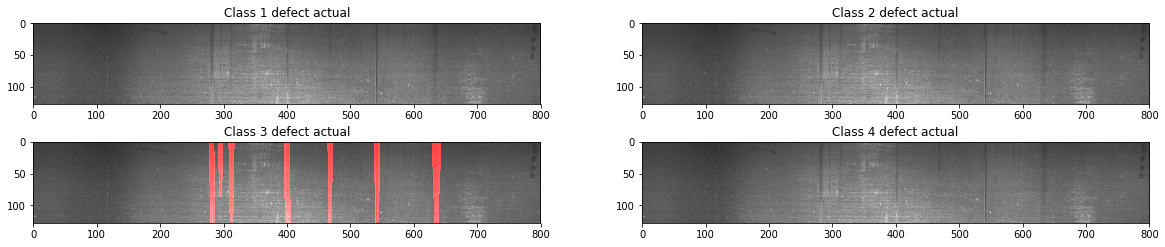

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))
data_path = '/content/drive/My Drive/' + 'train_images/'
f = test_df['ImageId'].iloc[13]
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = rle2mask( test_df['e'+str(i+1)].iloc[13])
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect actual".format(i+1))
  plt.imshow(img)
    
plt.show()

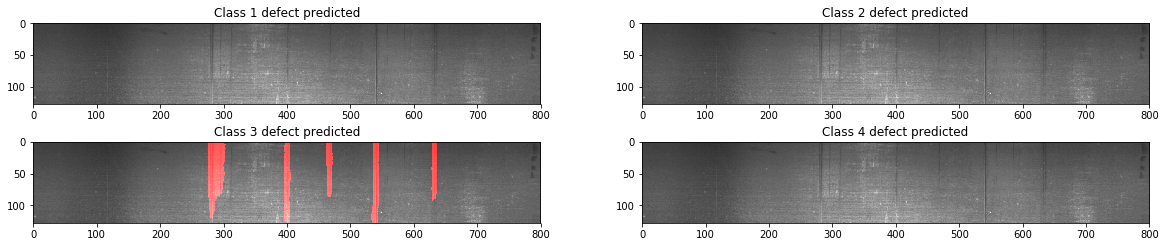

In [0]:
y_predicted = preds[13]
fig = plt.figure(figsize=(20,4))
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = y_predicted[:,:,i].round().astype(int)
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect predicted".format(i+1))
  plt.imshow(img)
    
plt.show()

In [0]:
# Predicting on test data
from tqdm import tqdm
data_path = '/content/drive/My Drive/' + 'test_images/'
files = list(os.listdir(data_path))
img_classId = []
rle_lst = []
for f in files:
  X = np.empty((1,128,800,3),dtype=np.float32)
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  X[0,] = img
  mask = model_n.predict(X)
  #print(mask[0,:,:,1].shape)
  rle_m = np.empty((128,800),dtype=np.uint8)
  for i in range(4):
    rle_m = mask[0,:,:,i].round().astype(int)
    rle = mask2rle(rle_m)
    rle_lst.append(rle)
    img_classId.append(f+'_'+str(i+1))
  
  


In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission1.csv', index=False)

In [0]:
from google.colab import files
files.download( "/content/submission1.csv" )    

# Training Model 2

In [0]:

inputs = Input((128,800,3))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='elu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='elu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='elu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='elu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (p4)
c5 = Conv2D(64, (3, 3), activation='elu', padding='same') (c5)
p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (p5)
c55 = Conv2D(128, (3, 3), activation='elu', padding='same') (c55)
    
u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
u6 = concatenate([u6, c5])
c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='elu', padding='same') (c6)

u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u71 = concatenate([u71, c4])
c71 = Conv2D(32, (3, 3), activation='elu', padding='same') (u71)
c61 = Conv2D(32, (3, 3), activation='elu', padding='same') (c71)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='elu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='elu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='elu', padding='same') (c9)
    
outputs = Conv2D(4, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef])

In [0]:
# Fit model
train_batches = DataGenerator(train_df,shuffle=True)
valid_batches = DataGenerator(cv_df)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 20, verbose=1)

Epoch 1/20
628/628 [==============================] - 160s 254ms/step - loss: 0.0565 - dice_coef: 0.0191 - val_loss: 0.0332 - val_dice_coef: 0.0275
Epoch 2/20
628/628 [==============================] - 151s 240ms/step - loss: 0.0340 - dice_coef: 0.0571 - val_loss: 0.0294 - val_dice_coef: 0.0727
Epoch 3/20
628/628 [==============================] - 152s 243ms/step - loss: 0.0286 - dice_coef: 0.1213 - val_loss: 0.0253 - val_dice_coef: 0.1654
Epoch 4/20
628/628 [==============================] - 151s 240ms/step - loss: 0.0236 - dice_coef: 0.2132 - val_loss: 0.0222 - val_dice_coef: 0.2016
Epoch 5/20
628/628 [==============================] - 150s 239ms/step - loss: 0.0215 - dice_coef: 0.2548 - val_loss: 0.0215 - val_dice_coef: 0.2658
Epoch 6/20
628/628 [==============================] - 151s 241ms/step - loss: 0.0188 - dice_coef: 0.2992 - val_loss: 0.0164 - val_dice_coef: 0.3089
Epoch 7/20
628/628 [==============================] - 151s 240ms/step - loss: 0.0167 - dice_coef: 0.3377 - val_l

In [0]:
from keras.models import load_model

model.save('my_model2.h5') 

In [0]:
from google.colab import files
files.download( "/content/my_model2.h5" )    

In [0]:
test_batches = DataGenerator2(test_df, subset='test',batch_size=1)
preds = model.predict_generator(test_batches,verbose=1)

1257/1257 [==============================] - 21s 17ms/step


### Tesing the model and visualizing

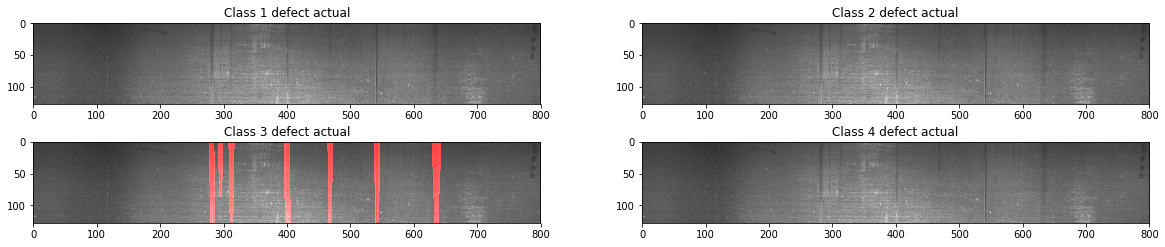

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))
data_path = '/content/drive/My Drive/' + 'train_images/'
f = test_df['ImageId'].iloc[13]
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = rle2mask( test_df['e'+str(i+1)].iloc[13])
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect actual".format(i+1))
  plt.imshow(img)
    
plt.show()

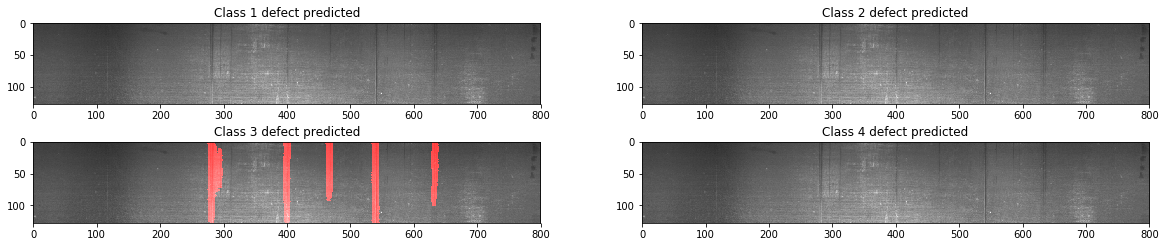

In [0]:
y_predicted = preds[13]
fig = plt.figure(figsize=(20,4))
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = y_predicted[:,:,i].round().astype(int)
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect predicted".format(i+1))
  plt.imshow(img)
    
plt.show()

In [0]:
# Predicting on test data
from tqdm import tqdm
data_path = '/content/drive/My Drive/' + 'test_images/'
files = list(os.listdir(data_path))
img_classId = []
rle_lst = []
for f in files:
  X = np.empty((1,128,800,3),dtype=np.float32)
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  X[0,] = img
  mask = model_n.predict(X)
  #print(mask[0,:,:,1].shape)
  rle_m = np.empty((128,800),dtype=np.uint8)
  for i in range(4):
    rle_m = mask[0,:,:,i].round().astype(int)
    rle = mask2rle(rle_m)
    rle_lst.append(rle)
    img_classId.append(f+'_'+str(i+1))
  

In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission2.csv',index=False)

In [0]:
from google.colab import files
files.download( "/content/submission2.csv" )    

# Using image segmentation model

In [15]:
! pip install segmentation-models

     |████████████████████████████████| 51kB 2.5MB/s 
     |████████████████████████████████| 81kB 7.5MB/s 


## Using vgg16 as backbone

In [0]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

# LOAD UNET WITH PRETRAINING FROM IMAGENET
preprocess = get_preprocessing('vgg16') # for resnet, img = (img-110.0)/1.0
model2 = Unet('vgg16', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
model2.compile(optimizer='adam', loss= bce_dice_loss, metrics=[dice_coef])
model2.summary()





58892288/58889256 [==============================] - 4s 0us/step





Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "u-vgg16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 128, 800, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 128, 800, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling

In [0]:
# TRAIN AND VALIDATE MODEL
train_batches = DataGenerator(train_df,shuffle=True,preprocess=preprocess)
valid_batches = DataGenerator(cv_df,preprocess=preprocess)
history = model2.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=1)

Epoch 1/30
628/628 [==============================] - 493s 785ms/step - loss: 0.5927 - dice_coef: 0.4499 - val_loss: 0.5689 - val_dice_coef: 0.4725
Epoch 2/30
628/628 [==============================] - 502s 799ms/step - loss: 0.5439 - dice_coef: 0.4957 - val_loss: 0.5050 - val_dice_coef: 0.5283
Epoch 3/30
628/628 [==============================] - 501s 798ms/step - loss: 0.5220 - dice_coef: 0.5153 - val_loss: 0.4931 - val_dice_coef: 0.5371
Epoch 4/30
628/628 [==============================] - 501s 798ms/step - loss: 0.5010 - dice_coef: 0.5356 - val_loss: 0.4850 - val_dice_coef: 0.5510
Epoch 5/30
628/628 [==============================] - 499s 795ms/step - loss: 0.4899 - dice_coef: 0.5460 - val_loss: 0.5179 - val_dice_coef: 0.5153
Epoch 6/30
628/628 [==============================] - 499s 795ms/step - loss: 0.4736 - dice_coef: 0.5608 - val_loss: 0.4604 - val_dice_coef: 0.5715
Epoch 7/30
628/628 [==============================] - 499s 794ms/step - loss: 0.4480 - dice_coef: 0.5849 - val_l

In [0]:
from keras.models import load_model
model2.save("/content/drive/My Drive/Project/my_model2.h5")

In [0]:
test_batches = DataGenerator2(test_df,preprocess=preprocess, batch_size=1, subset='test')
preds = model2.predict_generator(test_batches,verbose=1)

1257/1257 [==============================] - 763s 607ms/step


# Cases where model worked well

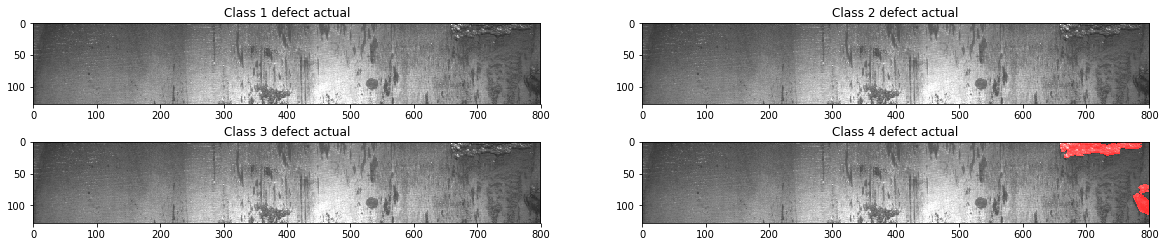

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))
data_path = '/content/drive/My Drive/' + 'train_images/'
f = test_df['ImageId'].iloc[2]
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = rle2mask( test_df['e'+str(i+1)].iloc[2])
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect actual".format(i+1))
  plt.imshow(img)
    
plt.show()

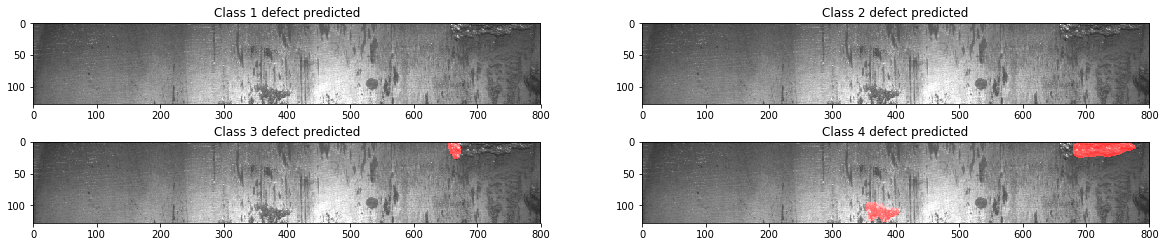

In [0]:
y_predicted = preds[2]
fig = plt.figure(figsize=(20,4))
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = y_predicted[:,:,i].round().astype(int)
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect predicted".format(i+1))
  plt.imshow(img)
    
plt.show()

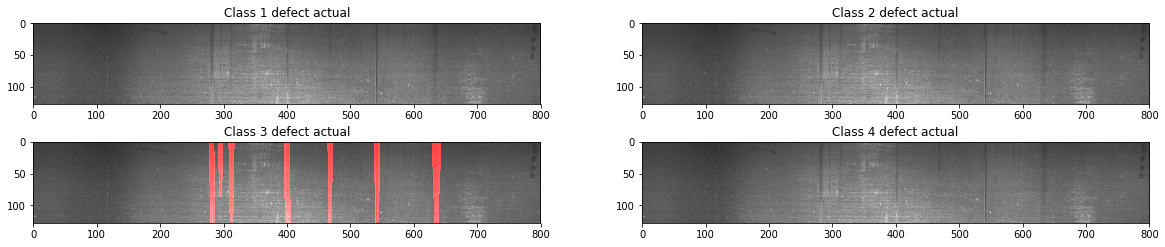

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))
data_path = '/content/drive/My Drive/' + 'train_images/'
f = test_df['ImageId'].iloc[13]
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = rle2mask( test_df['e'+str(i+1)].iloc[13])
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect actual".format(i+1))
  plt.imshow(img)
    
plt.show()

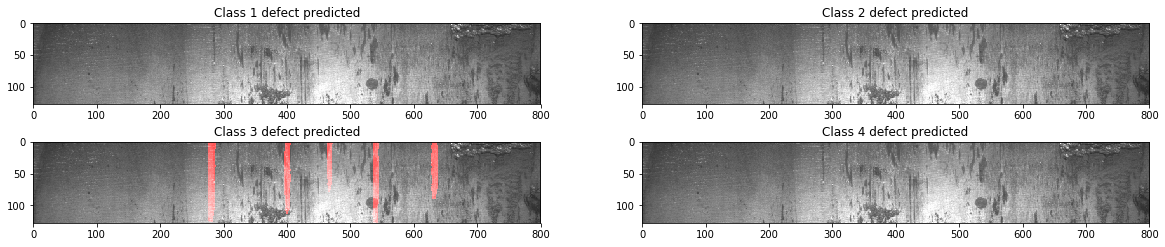

In [0]:
y_predicted = preds[13]
fig = plt.figure(figsize=(20,4))
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = y_predicted[:,:,i].round().astype(int)
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect predicted".format(i+1))
  plt.imshow(img)
    
plt.show()

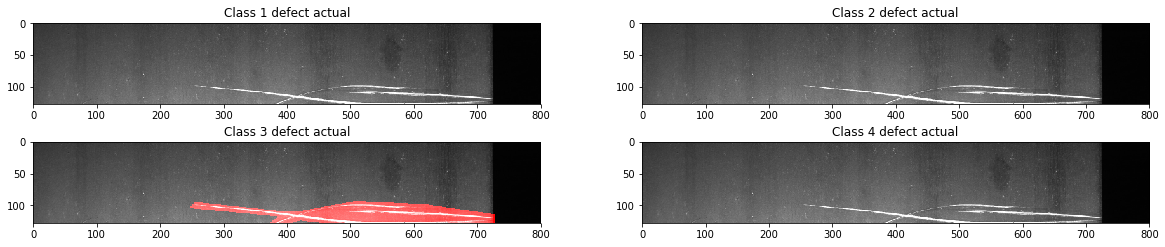

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))
data_path = '/content/drive/My Drive/' + 'train_images/'
f = test_df['ImageId'].iloc[19]
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = rle2mask( test_df['e'+str(i+1)].iloc[19])
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect actual".format(i+1))
  plt.imshow(img)
    
plt.show()

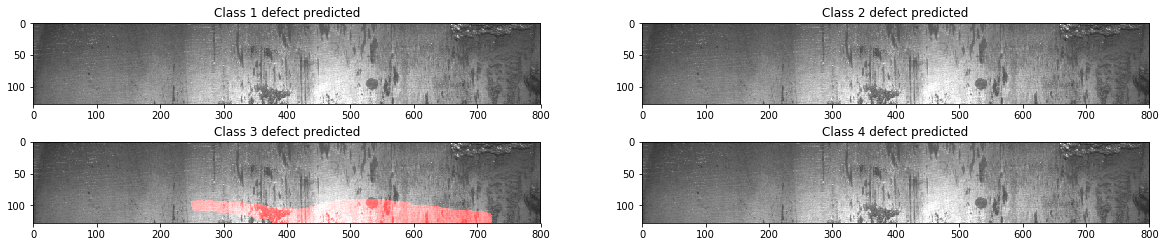

In [0]:
y_predicted = preds[19]
fig = plt.figure(figsize=(20,4))
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = y_predicted[:,:,i].round().astype(int)
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect predicted".format(i+1))
  plt.imshow(img)
    
plt.show()

# Cases where it failed

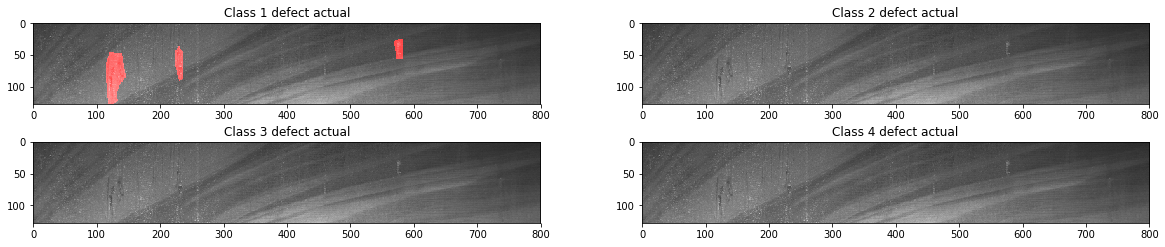

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))
data_path = '/content/drive/My Drive/' + 'train_images/'
f = test_df['ImageId'].iloc[5]
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = rle2mask( test_df['e'+str(i+1)].iloc[5])
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect actual".format(i+1))
  plt.imshow(img)
    
plt.show()

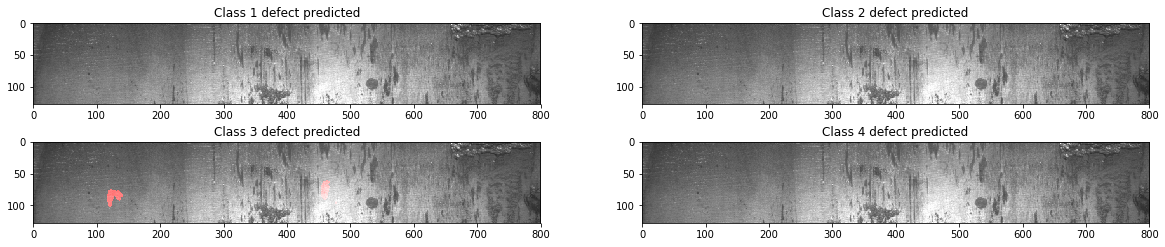

In [0]:
y_predicted = preds[5]
fig = plt.figure(figsize=(20,4))
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = y_predicted[:,:,i].round().astype(int)
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect predicted".format(i+1))
  plt.imshow(img)
    
plt.show()

## Using  restnet34 as backbone

In [0]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing

# LOAD UNET WITH PRETRAINING FROM IMAGENET
preprocess = get_preprocessing('resnet34') # for resnet, img = (img-110.0)/1.0
model3 = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
model3.compile(optimizer='adam', loss= bce_dice_loss, metrics=[dice_coef])
model3.summary()

85524480/85521592 [==============================] - 14s 0us/step
Model: "u-resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 128, 800, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 800, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 134, 806, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 400, 64)  9408        zero_padding2d_1[0][0]           
_______________________

In [0]:
# TRAIN AND VALIDATE MODEL
train_batches = DataGenerator(train_df,shuffle=True,preprocess=preprocess)
valid_batches = DataGenerator(cv_df,preprocess=preprocess)
history = model3.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=1)

Epoch 1/30
628/628 [==============================] - 318s 506ms/step - loss: 0.6975 - dice_coef: 0.3617 - val_loss: 0.7048 - val_dice_coef: 0.3381
Epoch 2/30
628/628 [==============================] - 315s 501ms/step - loss: 0.5771 - dice_coef: 0.4649 - val_loss: 0.6261 - val_dice_coef: 0.4099
Epoch 3/30
628/628 [==============================] - 314s 500ms/step - loss: 0.5377 - dice_coef: 0.5017 - val_loss: 0.5179 - val_dice_coef: 0.5219
Epoch 4/30
628/628 [==============================] - 315s 502ms/step - loss: 0.5103 - dice_coef: 0.5274 - val_loss: 1.0113 - val_dice_coef: 0.1974
Epoch 5/30
628/628 [==============================] - 314s 500ms/step - loss: 0.5112 - dice_coef: 0.5259 - val_loss: 0.5543 - val_dice_coef: 0.4800
Epoch 6/30
628/628 [==============================] - 314s 500ms/step - loss: 0.4956 - dice_coef: 0.5401 - val_loss: 0.4936 - val_dice_coef: 0.5436
Epoch 7/30
628/628 [==============================] - 314s 500ms/step - loss: 0.4782 - dice_coef: 0.5559 - val_l

In [0]:
from keras.models import load_model
model3.save("/content/drive/My Drive/Project/my_model3.h5")

In [0]:
test_batches = DataGenerator2(test_df,preprocess=preprocess, subset='test')
preds = model3.predict_generator(test_batches,verbose=1)

78/78 [==============================] - 16s 209ms/step


# Cases where the model worked

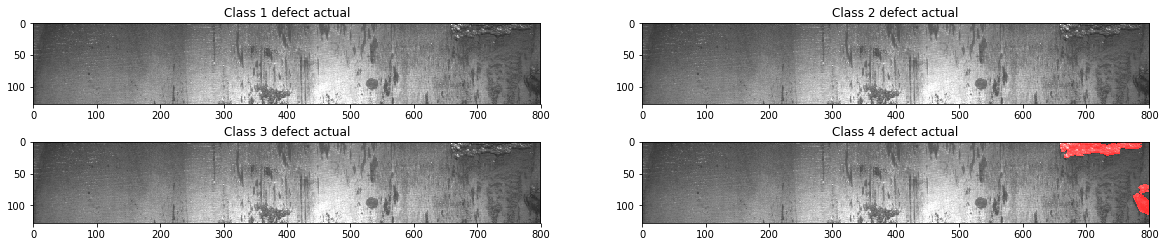

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))
data_path = '/content/drive/My Drive/' + 'train_images/'
f = test_df['ImageId'].iloc[2]
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = rle2mask( test_df['e'+str(i+1)].iloc[2])
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect actual".format(i+1))
  plt.imshow(img)
    
plt.show()

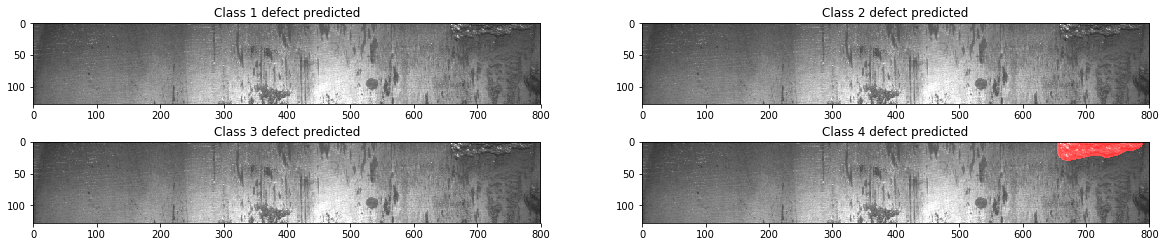

In [0]:
y_predicted = preds[2]
fig = plt.figure(figsize=(20,4))
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = y_predicted[:,:,i].round().astype(int)
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect predicted".format(i+1))
  plt.imshow(img)
    
plt.show()

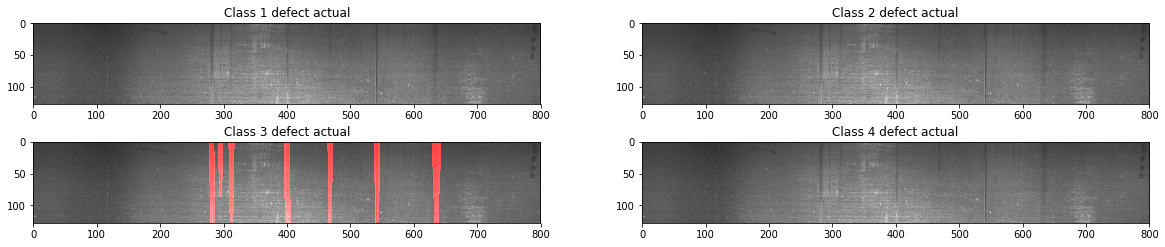

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))
data_path = '/content/drive/My Drive/' + 'train_images/'
f = test_df['ImageId'].iloc[13]
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = rle2mask( test_df['e'+str(i+1)].iloc[13])
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect actual".format(i+1))
  plt.imshow(img)
    
plt.show()

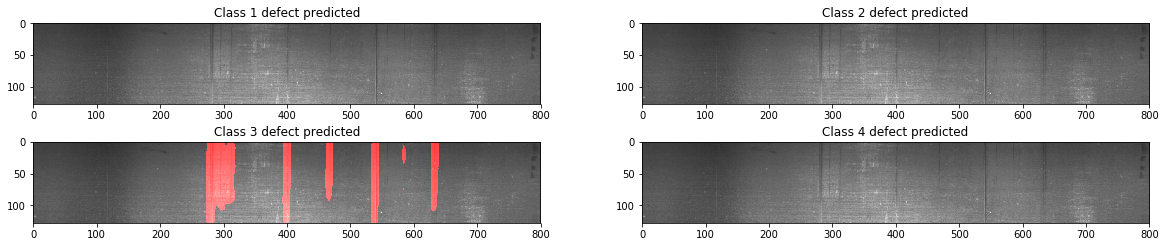

In [0]:
y_predicted = preds[13]
fig = plt.figure(figsize=(20,4))
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = y_predicted[:,:,i].round().astype(int)
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect predicted".format(i+1))
  plt.imshow(img)
    
plt.show()

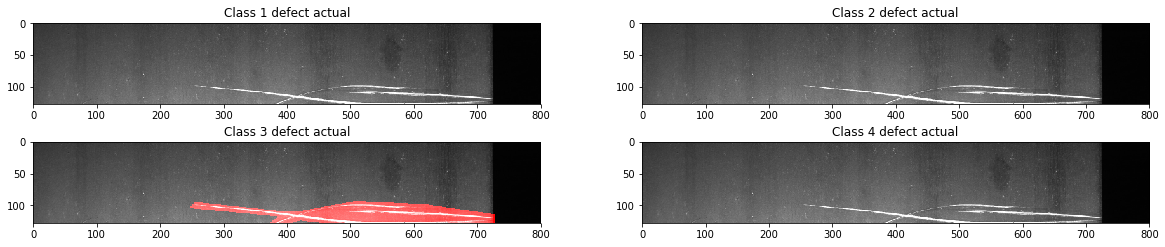

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))
data_path = '/content/drive/My Drive/' + 'train_images/'
f = test_df['ImageId'].iloc[19]
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = rle2mask( test_df['e'+str(i+1)].iloc[19])
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect actual".format(i+1))
  plt.imshow(img)
    
plt.show()

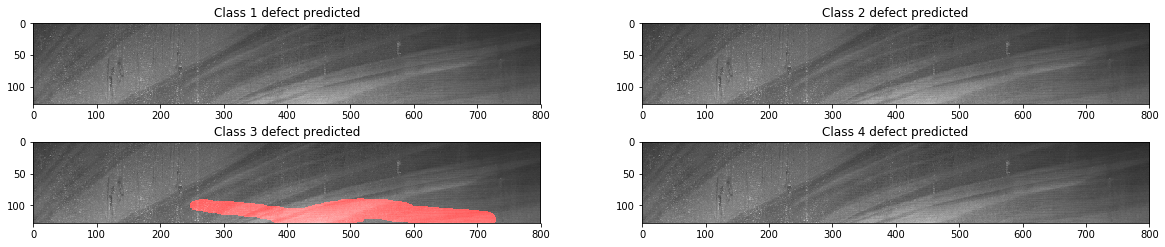

In [0]:
y_predicted = preds[19]
fig = plt.figure(figsize=(20,4))
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = y_predicted[:,:,i].round().astype(int)
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect predicted".format(i+1))
  plt.imshow(img)
    
plt.show()

# Cases where the model failed

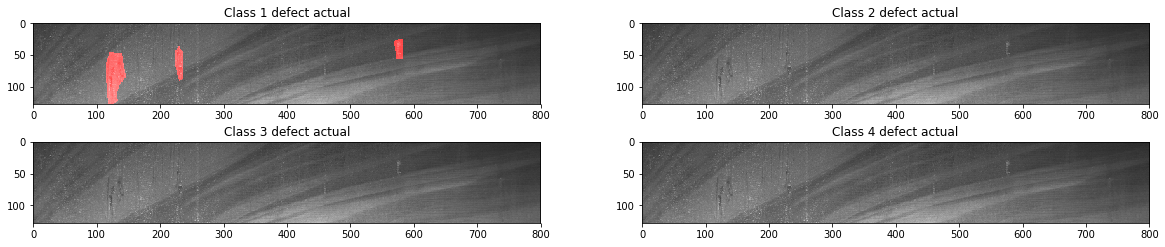

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,4))
data_path = '/content/drive/My Drive/' + 'train_images/'
f = test_df['ImageId'].iloc[5]
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = rle2mask( test_df['e'+str(i+1)].iloc[5])
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect actual".format(i+1))
  plt.imshow(img)
    
plt.show()

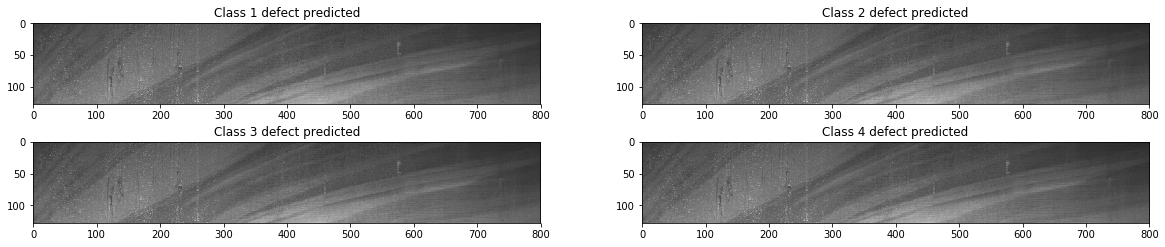

In [0]:
y_predicted = preds[5]
fig = plt.figure(figsize=(20,4))
for i in range(4):
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  mask = y_predicted[:,:,i].round().astype(int)
  img[mask==1,0] = 255
  fig.add_subplot(2, 2, i+1)
  plt.title("Class {} defect predicted".format(i+1))
  plt.imshow(img)
    
plt.show()

# Predicting the output on test dataset and saving the output

In [0]:
# Predicting on training data
from tqdm import tqdm
data_path = '/content/drive/My Drive/' + 'test_images/'
files = list(os.listdir(data_path))
img_classId = []
rle_lst = []
for f in files:
  X = np.empty((1,128,800,3),dtype=np.float32)
  img = cv2.imread(data_path + f)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (800,128))
  X[0,] = img
  mask = model2.predict(X)
  #print(mask[0,:,:,1].shape)
  rle_m = np.empty((128,800),dtype=np.uint8)
  for i in range(4):
    rle_m = mask[0,:,:,i].round().astype(int)
    rle = mask2rle(rle_m)
    rle_lst.append(rle)
    img_classId.append(f+'_'+str(i+1))
  
  


In [0]:
output = {'ImageId_ClassId':img_classId, 'EncodedPixels' : rle_lst}
import pandas as pd
output_df = pd.DataFrame(output)
output_df.to_csv('submission.csv', index=False)

# Conclusion

### The best model was Unet with vgg16 as background which gave us a dice coefficient of 0.8127 on public leader board on kaggle.